In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits

In [9]:
beam_path = r'/mnt/d/SPIRE-SR-AI/data/raw/beams'

beam_files = ['PRIMA_PHI1_1.fits', 'PRIMA_PHI2_16.fits', 'PRIMA_PPI1.fits', 'PRIMA_PPI3.fits']

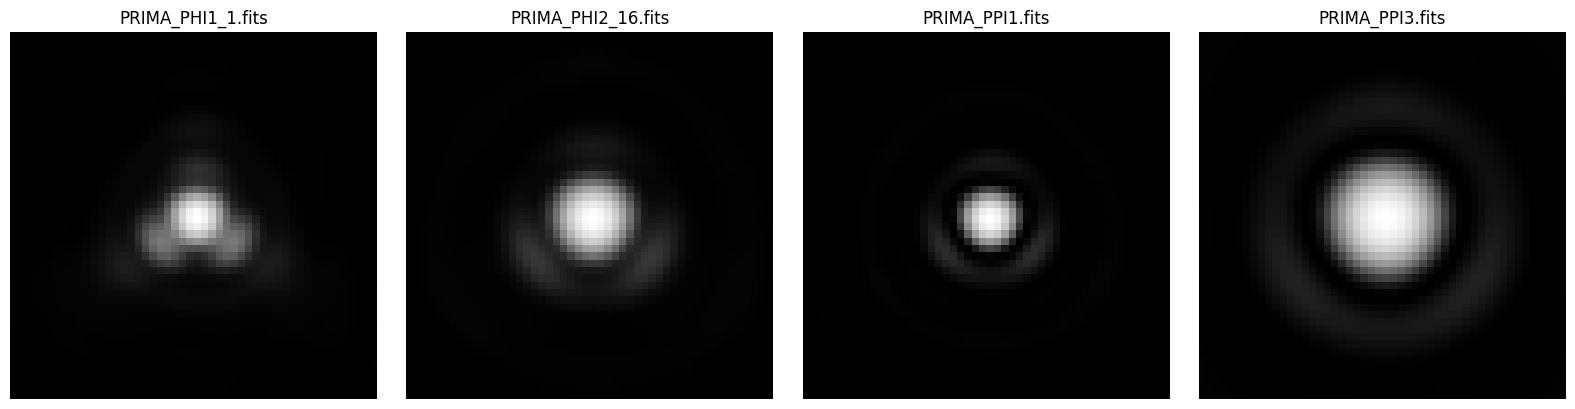

In [10]:
from astropy.visualization import AsinhStretch, ImageNormalize

# Crop function to extract a 50x50 cut around the center of the image
def crop_center(data, crop_size=50):
    h, w = data.shape
    half_crop = crop_size // 2
    center_y, center_x = h // 2, w // 2
    return data[center_y - half_crop:center_y + half_crop,
                center_x - half_crop:center_x + half_crop]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, file in enumerate(beam_files):
    # Construct full file path
    file_path = os.path.join(beam_path, file)
    
    # Open the FITS file
    with fits.open(file_path) as hdul:
        # Get the image data from the primary HDU
        data = hdul[0].data
        data = crop_center(data)
    
    # Plot the image data using imshow
    norm = ImageNormalize(stretch=AsinhStretch())
    im = axes[i].imshow(data, cmap='gray', norm=norm)
    axes[i].set_title(file)
    axes[i].axis('off')  # Hide axis ticks for clarity

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [19]:
pixel_scales = []
for file in beam_files:
    file_path = os.path.join(beam_path, file)
    with fits.open(file_path) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    
    print(f'{file}: {data.shape}')
    px = header.get('CDELT1', None)
    py = header.get('CDELT2', None)
    print(f'Pixel scales for {file}: x = {px}, y = {py}\n')
    pixel_scales.append((px, py))

print("Pixel scales for each beam file:")
for file, scales in zip(beam_files, pixel_scales):
    print(f"{file}: x = {scales[0]}, y = {scales[1]}")


PRIMA_PHI1_1.fits: (143, 143)
Pixel scales for PRIMA_PHI1_1.fits: x = 0.8, y = 0.8

PRIMA_PHI2_16.fits: (195, 195)
Pixel scales for PRIMA_PHI2_16.fits: x = 1.3, y = 1.3

PRIMA_PPI1.fits: (141, 141)
Pixel scales for PRIMA_PPI1.fits: x = 2.3, y = 2.3

PRIMA_PPI3.fits: (279, 279)
Pixel scales for PRIMA_PPI3.fits: x = 2.3, y = 2.3

Pixel scales for each beam file:
PRIMA_PHI1_1.fits: x = 0.8, y = 0.8
PRIMA_PHI2_16.fits: x = 1.3, y = 1.3
PRIMA_PPI1.fits: x = 2.3, y = 2.3
PRIMA_PPI3.fits: x = 2.3, y = 2.3


Processing: PRIMA_PHI1_1.fits
Fitted parameters for PRIMA_PHI1_1.fits
Amplitude: 0.919665397845337
x0:       70.99373711928584
y0:       70.88765946802111
sigma_x:  2.3091321751938696
sigma_y:  2.14139334338927
FWHM:     5.438006272581563
offset:   0.0008062394867985811


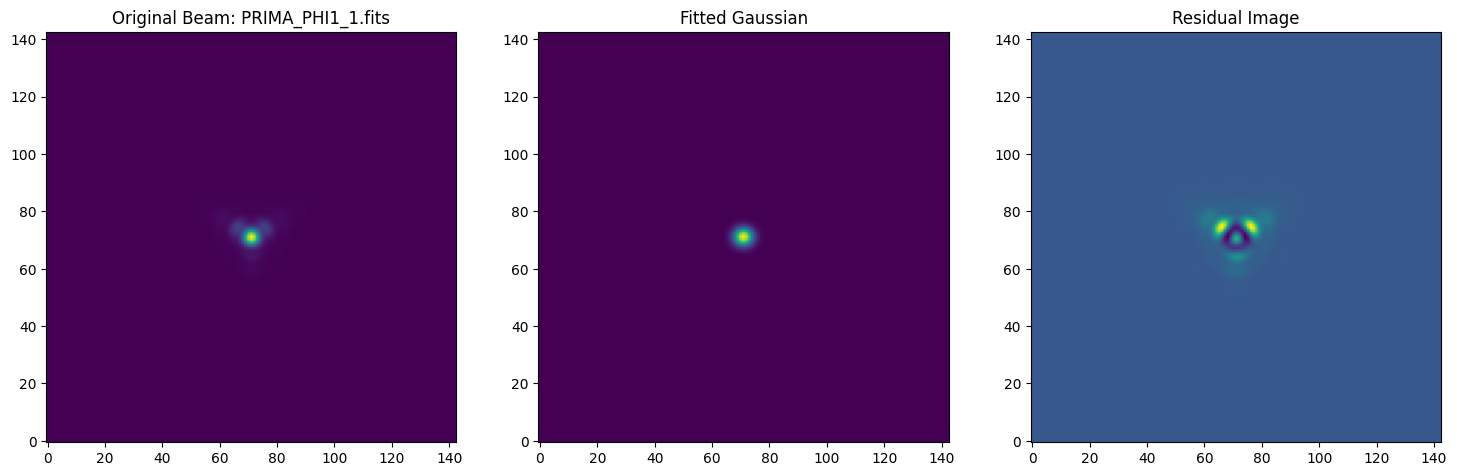

Processing: PRIMA_PHI2_16.fits
Fitted parameters for PRIMA_PHI2_16.fits
Amplitude: 1.014714326156191
x0:       96.99903847880078
y0:       96.93655270613087
sigma_x:  2.7154850498086933
sigma_y:  2.6977695679958824
FWHM:     6.394967292299473
offset:   0.00038255289591774833


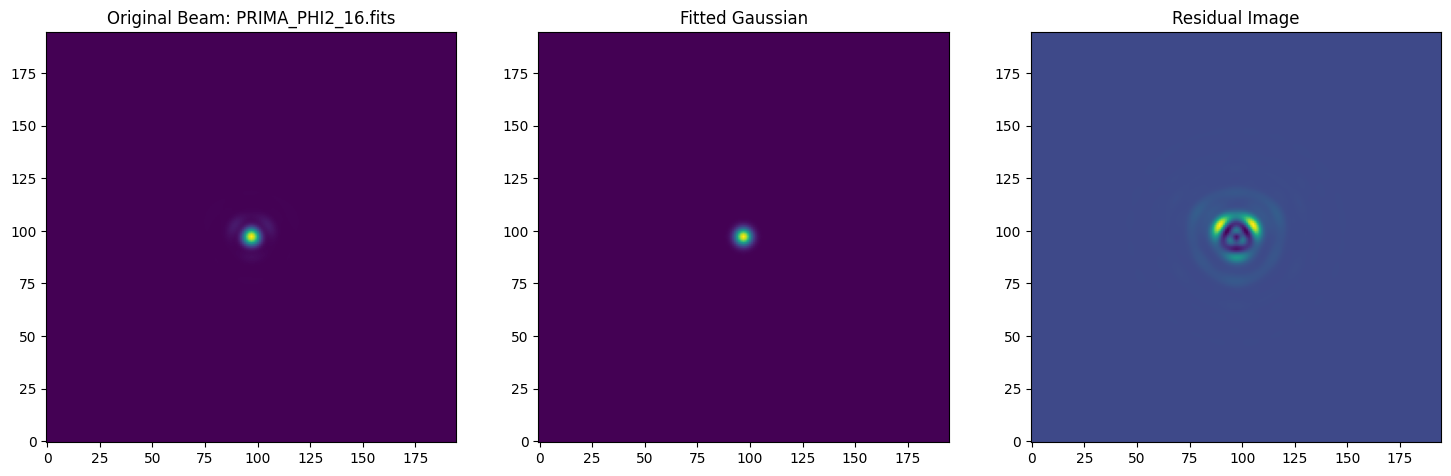

Processing: PRIMA_PPI1.fits
Fitted parameters for PRIMA_PPI1.fits
Amplitude: 1.0464288671314552
x0:       69.99949736409631
y0:       69.95240409596947
sigma_x:  1.8862539491159742
sigma_y:  1.8704062195385243
FWHM:     4.442128050168119
offset:   0.00027698351999873934


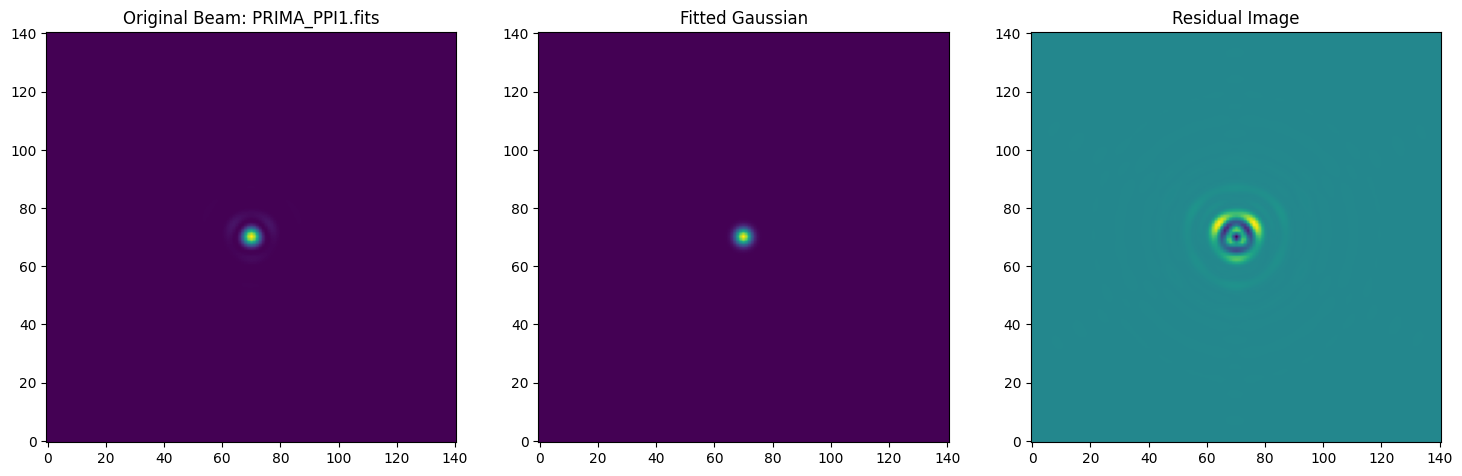

Processing: PRIMA_PPI3.fits
Fitted parameters for PRIMA_PPI3.fits
Amplitude: 1.0473032590965539
x0:       138.99952256516508
y0:       138.9561324192126
sigma_x:  3.728277397657727
sigma_y:  3.709174681711676
FWHM:     8.780093271483947
offset:   0.0002503879280509879


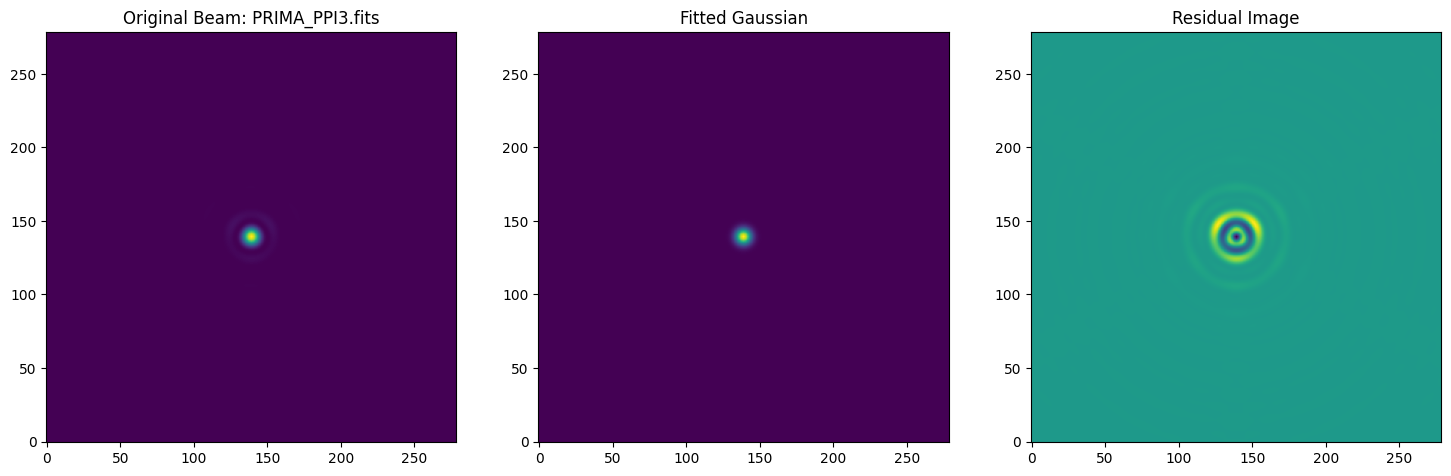

In [ ]:
from scipy.optimize import curve_fit

# Define a 2D Gaussian function (defined once)
def twoD_Gaussian(coords, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = coords
    return amplitude * np.exp( - ( ((x - x0)**2) / (2*sigma_x**2) 
                                 + ((y - y0)**2) / (2*sigma_y**2) ) ) + offset

# Loop over each beam file
for pix_scale, file in zip(pixel_scales, beam_files):
    print("Processing:", file)
    file_path = os.path.join(beam_path, file)
    
    # Open the FITS file and extract image data
    with fits.open(file_path) as hdul:
        data_beam = hdul[0].data

    # Create coordinate grids based on the image shape
    y_indices, x_indices = np.indices(data_beam.shape)
    
    # Initial guess for the Gaussian parameters: amplitude, x0, y0, sigma_x, sigma_y, offset
    initial_guess = (data_beam.max() - data_beam.min(),
                     data_beam.shape[1] / 2,
                     data_beam.shape[0] / 2,
                     10, 10,
                     data_beam.min())
    
    # Flatten grid and data for fitting
    xdata = np.vstack((x_indices.ravel(), y_indices.ravel()))
    ydata = data_beam.ravel()
    
    # Fit the Gaussian model
    popt, _ = curve_fit(twoD_Gaussian, xdata, ydata, p0=initial_guess)
    
    # Print the fitted parameters
    print("Fitted parameters for", file)
    print("Amplitude:", popt[0])
    print("x0:      ", popt[1])
    print("y0:      ", popt[2])
    print("sigma_x: ", popt[3] * pix_scale[0])
    print("sigma_y: ", popt[4] * pix_scale[0])
    print("FWHM:    ", popt[3] * 2.355 * pix_scale[0])
    print("offset:  ", popt[5])
    
    # Create the fitted model using the optimal parameters
    data_fit = twoD_Gaussian((x_indices, y_indices), *popt).reshape(data_beam.shape)
    
    # Compute residual image (original beam - fitted Gaussian)
    residual = data_beam - data_fit
    
    # Plot the original beam image, the fitted Gaussian, and the residual image
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(data_beam, origin='lower', cmap='viridis')
    ax[0].set_title("Original Beam: " + file)
    ax[1].imshow(data_fit, origin='lower', cmap='viridis')
    ax[1].set_title("Fitted Gaussian")
    ax[2].imshow(residual, origin='lower', cmap='viridis')
    ax[2].set_title("Residual Image")
    plt.show()